## Análise Exploratória e Modelagem Preditiva no Dataset Titanic - Terceira Avaliação Redes Neurais
### Discente: João Pedro de Alcântara Lima

#### 1. Análise Exploratória dos Dados

O processo se inicia com a análise quantitativa e relativa da sobrevivência (`Survived`) em relação ao sexo (`Sex`). Foram calculadas tanto as contagens absolutas quanto os percentuais de sobreviventes para cada sexo, permitindo identificar possíveis desbalanceamentos entre os grupos.

Contagem absoluta de sobreviventes por sexo:
Survived    0    1
Sex               
female     81  233
male      468  109

Percentual de sobreviventes por sexo:
Survived          0          1
Sex                           
female    25.796178  74.203822
male      81.109185  18.890815


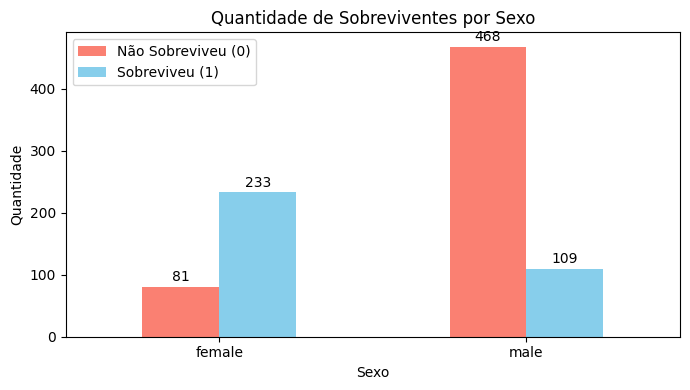

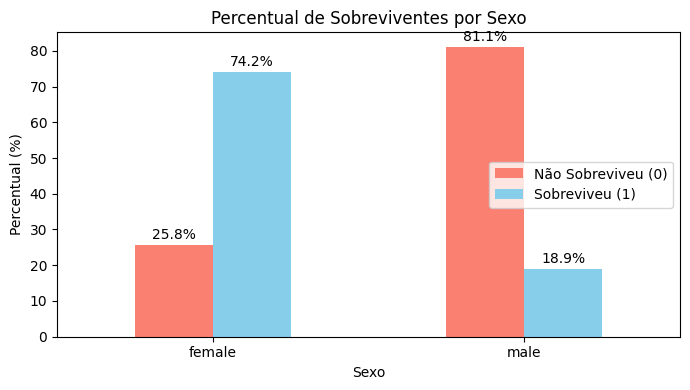

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 1. Análise quantitativa e relativa de Survived em relação ao Sex
survived_sex_counts = train_df.groupby('Sex')['Survived'].value_counts().unstack().fillna(0)
survived_sex_percent = survived_sex_counts.div(survived_sex_counts.sum(axis=1), axis=0) * 100

print("Contagem absoluta de sobreviventes por sexo:")
print(survived_sex_counts)
print("\nPercentual de sobreviventes por sexo:")
print(survived_sex_percent)

# Plotagem da quantidade absoluta
ax1 = survived_sex_counts.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Quantidade de Sobreviventes por Sexo')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax1.containers:
    ax1.bar_label(container, padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

# Plotagem do percentual
ax2 = survived_sex_percent.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Percentual de Sobreviventes por Sexo')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

#### 2. Criação da Variável Combinada `SurvivedPclass`
Em seguida, foram gerados gráficos para visualizar:
- A distribuição dos passageiros por classe (`Pclass`) e sexo.
- A distribuição da nova variável combinada `SurvivedPclass` por sexo, que representa a combinação entre sobrevivência e classe social.

Essas visualizações evidenciam o desbalanceamento de classes, especialmente quando se observa a sobrevivência em função do sexo e da classe.

Para mitigar o desbalanceamento observado, foi criada a variável `SurvivedPclass`, que combina as informações de sobrevivência e classe social. Essa abordagem permite que o modelo aprenda com as classes já balanceadas entre os diferentes grupos de passageiros.

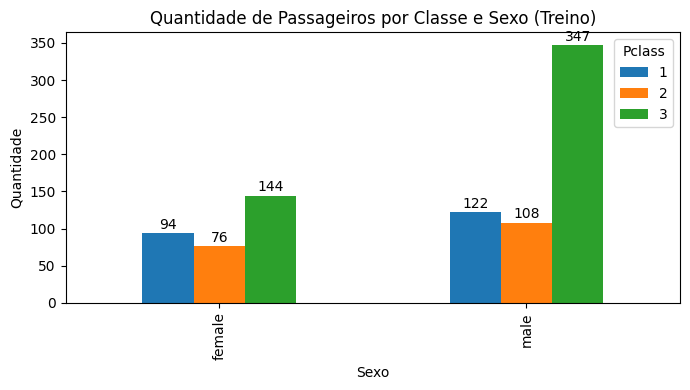

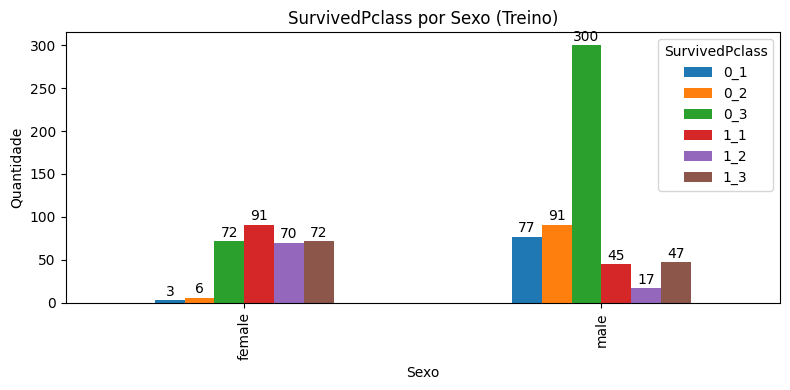

In [2]:
ct = pd.crosstab(train_df['Sex'], train_df['Pclass'])

fig, ax = plt.subplots(figsize=(7,4))
bars = ct.plot(kind='bar', ax=ax) 

plt.title('Quantidade de Passageiros por Classe e Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

# 3. Criar a nova classe combinada SurvivedPclass
train_df['SurvivedPclass'] = train_df['Survived'].astype(str) + '_' + train_df['Pclass'].astype(str)

ct = pd.crosstab(train_df['Sex'], train_df['SurvivedPclass'])

fig, ax = plt.subplots(figsize=(8,4))
bars = ct.plot(kind='bar', ax=ax) 

plt.title('SurvivedPclass por Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='SurvivedPclass')
plt.tight_layout()
plt.show()

#### 3. Modelagem Preditiva

O modelo escolhido foi o **Random Forest**, que recebeu como entrada as variáveis `Sex` e `Pclass` para prever a nova variável `SurvivedPclass`. Após o treinamento, o modelo foi utilizado para prever `SurvivedPclass` no conjunto de teste.

##### Por que escolher o modelo Random Forest?

O **Random Forest** foi escolhido por ser um modelo de aprendizado de máquina robusto para tarefas de classificação, especialmente quando há variáveis categóricas e possíveis relações não lineares entre as features. Suas principais vantagens são:

- **Capacidade de lidar com desbalanceamento:** Random Forest pode ser ajustado para considerar o peso das classes, ajudando a mitigar problemas de desbalanceamento.
- **Redução de overfitting:** Por ser um conjunto de várias árvores de decisão, o Random Forest tende a generalizar melhor do que uma única árvore, reduzindo o risco de overfitting.
- **Interpretação dos resultados:** Permite avaliar a importância de cada variável na decisão final do modelo.

Essas características tornam o Random Forest uma boa escolha para o problema do Titanic, onde queremos prever a sobrevivência a partir de variáveis como sexo e classe social, levando em conta o desbalanceamento natural do conjunto de dados.

A partir da previsão de `SurvivedPclass`, foi extraído o valor final de sobrevivência (`Survived`), considerando apenas o primeiro caractere da string combinada.

In [3]:
from sklearn.ensemble import RandomForestClassifier

# 2. Codificar Sex para valores numéricos
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# 3. Criar a variável combinada SurvivedPclass
train_df['SurvivedPclass'] = train_df['Survived'].astype(str) + '_' + train_df['Pclass'].astype(str)

# Oversampling para balancear as classes
target = 'SurvivedPclass'
max_count = train_df[target].value_counts().max()
train_df_balanced = pd.concat([
    group.sample(max_count, replace=True, random_state=42)
    for _, group in train_df.groupby(target)
])

# 4. Treinar modelo Random Forest para prever SurvivedPclass
features = ['Sex', 'Pclass']
X_train = train_df_balanced[features]
y_train = train_df_balanced['SurvivedPclass']

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 5. Prever SurvivedPclass no teste
X_test = test_df[features]
test_df['SurvivedPclass_pred'] = model.predict(X_test)

# 6. Extrair Survived final da previsão (primeiro caractere da string)
test_df['Survived'] = test_df['SurvivedPclass_pred'].str[0].astype(int)

# 7. Gerar arquivo de submissão
submission = test_df[['PassengerId', 'Survived']]
submission.to_csv('my_submission.csv', index=False)
print(submission)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


#### 4. Avaliação do Modelo

O desempenho do modelo foi avaliado no próprio conjunto de treino, extraindo novamente o valor de `Survived` a partir da previsão de `SurvivedPclass`. Foram calculadas as principais métricas de classificação:
- **Acurácia**
- **Precisão**
- **Recall**
- **F1-score**

Essas métricas permitem avaliar o quanto o modelo conseguiu aprender os padrões de sobrevivência, considerando o balanceamento promovido pela variável combinada.


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# 8. Avaliar o modelo no conjunto de treino balanceado (usando Survived extraído de SurvivedPclass)
train_df_balanced['SurvivedPclass_pred'] = model.predict(X_train)
train_df_balanced['Survived_pred'] = train_df_balanced['SurvivedPclass_pred'].str[0].astype(int)

y_true = train_df_balanced['Survived']
y_pred = train_df_balanced['Survived_pred']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('\nRelatório de Classificação:')
print(classification_report(y_true, y_pred))

Acurácia: 0.7953
Precisão: 0.8698
Recall: 0.6944

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.90      0.81      1116
           1       0.87      0.69      0.77      1116

    accuracy                           0.80      2232
   macro avg       0.81      0.80      0.79      2232
weighted avg       0.81      0.80      0.79      2232



## Plotar a distribuição das classes SurvivedPclass após o oversampling.

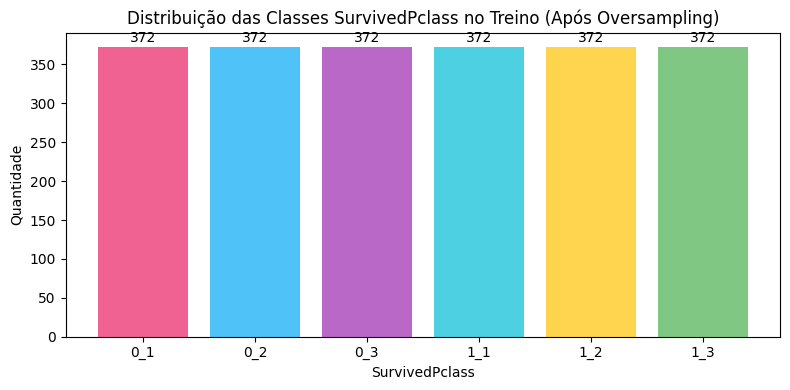

In [5]:
class_counts = train_df_balanced['SurvivedPclass'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8,4))
bars = ax.bar(class_counts.index, class_counts.values, color=['#F06292', '#4FC3F7', '#BA68C8', '#4DD0E1', '#FFD54F', '#81C784'])
ax.set_title('Distribuição das Classes SurvivedPclass no Treino (Após Oversampling)')
ax.set_ylabel('Quantidade')
ax.set_xlabel('SurvivedPclass')
ax.bar_label(bars, padding=2)
plt.tight_layout()
plt.show()

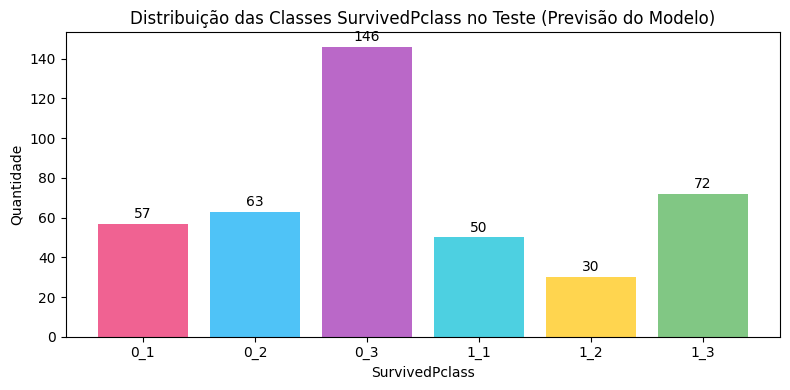

In [6]:
class_counts_test = test_df['SurvivedPclass_pred'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(8,4))
bars = ax.bar(class_counts_test.index, class_counts_test.values, color=['#F06292', '#4FC3F7', '#BA68C8', '#4DD0E1', '#FFD54F', '#81C784'])
ax.set_title('Distribuição das Classes SurvivedPclass no Teste (Previsão do Modelo)')
ax.set_ylabel('Quantidade')
ax.set_xlabel('SurvivedPclass')
ax.bar_label(bars, padding=2)
plt.tight_layout()
plt.show()

### Por que as classes previstas no teste ficaram desbalanceadas?

Apesar do oversampling ter balanceado as classes no conjunto de **treino**, o gráfico acima mostra que as previsões do modelo no conjunto de **teste** ainda ficaram desbalanceadas.

#### Motivos:

- **Distribuição real dos dados:**  
  O conjunto de teste reflete a distribuição real dos passageiros do Titanic, que naturalmente é desbalanceada entre as diferentes combinações de sobrevivência e classe social (`SurvivedPclass`). O oversampling só afeta o treino, não o teste.

- **Capacidade do modelo:**  
  Mesmo treinado em dados balanceados, o modelo aprende padrões baseados nas características dos passageiros. Se certas combinações de sexo e classe são mais comuns no teste, o modelo tende a prever mais essas classes.

- **Generalização:**  
  O objetivo do balanceamento no treino é evitar que o modelo seja enviesado para as classes majoritárias. No entanto, ao ser aplicado ao teste, o modelo faz previsões de acordo com o que "vê" nos dados de entrada, que podem não estar igualmente distribuídos.

O importante é que o modelo, treinado em dados balanceados, não ignore as classes